# Simulating subset sum oracle

This notebook records the result of simulating the subset sum oracle for a small list. The simulation is done on the ionq simulator using Microsoft's Azure Quantum service.

In [1]:
from azure.quantum.qiskit import AzureQuantumProvider
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

provider = AzureQuantumProvider (
    resource_id = "/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b",
    location = "westus"
)

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:
Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)
[171890:171890:0100/000000.837710:ERROR:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.


- ionq.qpu
- ionq.simulator
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s1-sim
- quantinuum.hqs-lt-s2-sim


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [3]:
from subset_sum_oracle import SubsetSumOracle

A subset sum oracle is constructed for the list $A=[5,7,8,9,1]$ and target sum $15$. There are two feasible subsets with bitstrings 10011 and 01100. The implementation in the accompanying file is a phase flip version. Here we simulate a bit-flip version and observe its outputs on a uniform superposition of all subsets. The sum of elements computed using the multi-adder is computed in the second register, and is uncomputed later, **and** it must be 0 for the oracle to function correctly. Remember that the Draper adder just adds values inplace.

$ \sum _{S \subseteq A}|S\rangle|0\rangle|0\rangle \rightarrow \sum _{S \subseteq A} |S\rangle|0\rangle|(\sum _{v\in S} v) (mod 16) = 15\rangle $

In [4]:
I = QuantumRegister(5)
V = QuantumRegister(5)
A = QuantumRegister(1)
R = ClassicalRegister(11)

circ = QuantumCircuit(I, V, A, R)

circ.h(I)

circ.h(A)
circ.x(A)

subset_sum_oracle_circ = SubsetSumOracle(15, [5,7,8,9,1], I, V, A)

circ.compose(subset_sum_oracle_circ, [*I]+[*V]+[*A], inplace=True)
circ.x(A)
circ.h(A)

circ.measure([*I]+[*V]+[*A], R)

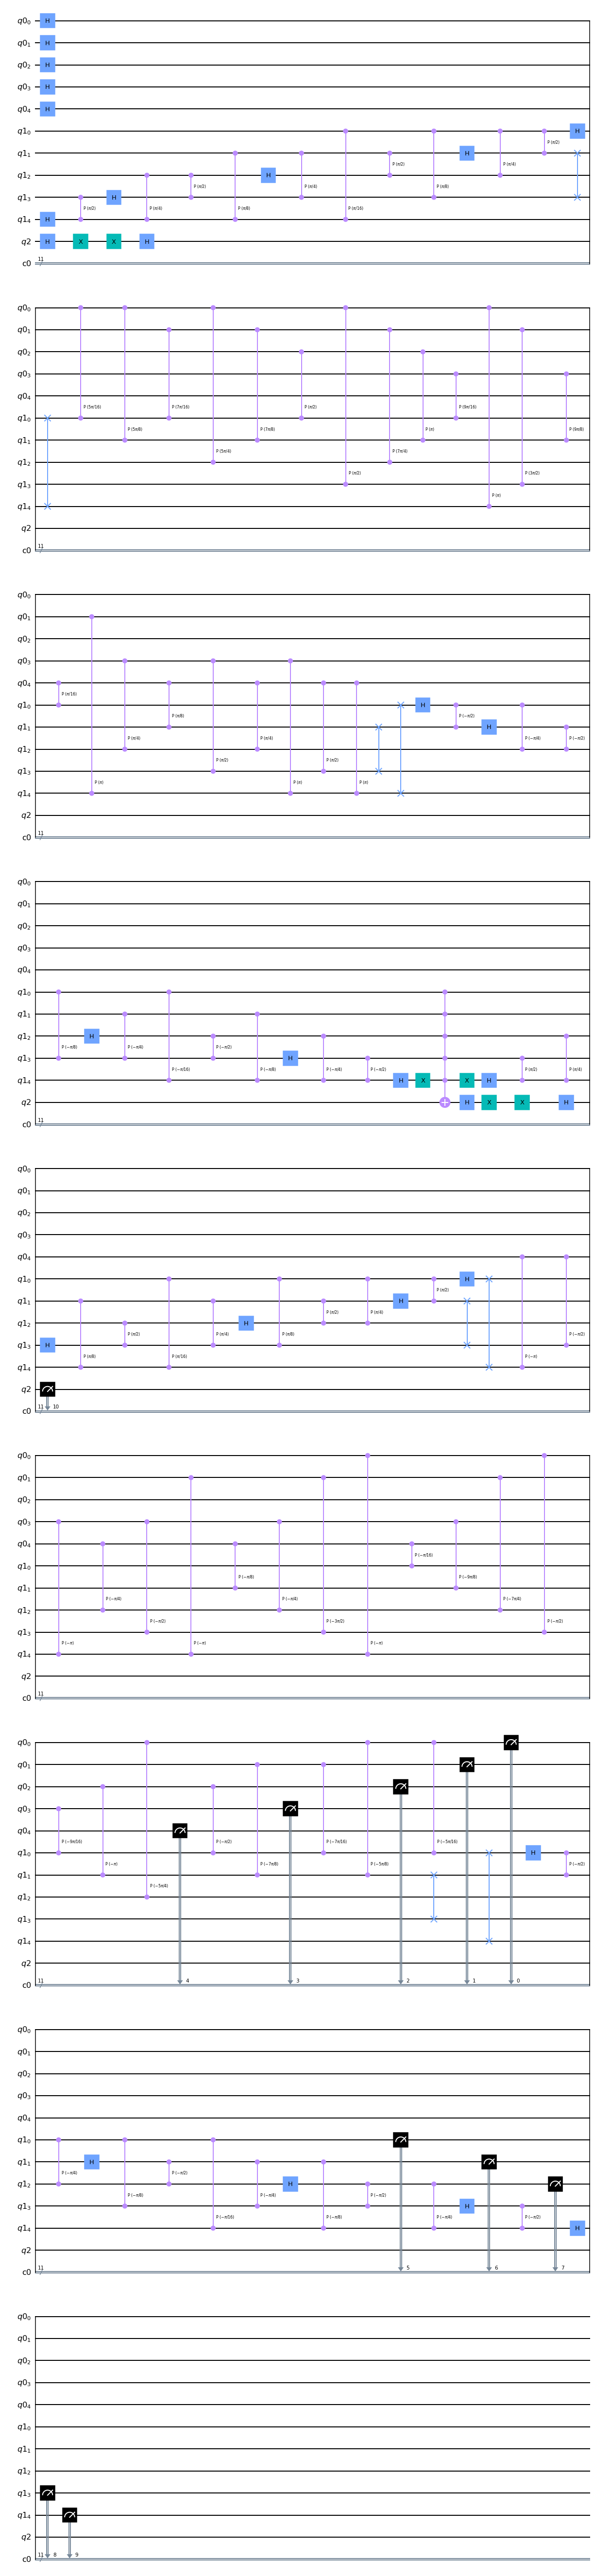

In [5]:
circ.draw("mpl")

In [6]:
ionq_simulator_backend = provider.get_backend("ionq.simulator")

In [7]:
job = ionq_simulator_backend.run(circ, shots=100)
print("Job id:", job.id())

Job id: f3a29550-b85f-11ec-848f-9843fa02ff35


In [8]:
job_monitor(job)

Job Status: job has successfully run


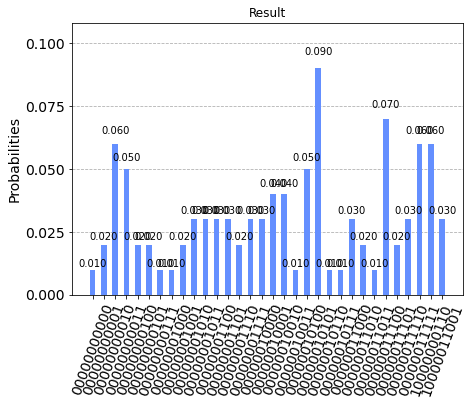

In [9]:
result = job.result()
plot_histogram(result.get_counts(circ), title="Result")

The only inputs with the last bit flipped are the feasible ones. The outputs are what we expected, suggesting the the oracle construction is correct. The final objective will be to use amplitude amplification to boost the probabilities of obtaining feasible subsets.